In [1]:
# Import teh relevant libraries
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prettytable import PrettyTable
from scipy.optimize import curve_fit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

In [2]:
# Source and clean the data
source_df = pd.read_csv("Source_data/Source_file.csv")          # Read in the source data
cleansed_df = source_df.loc[(source_df["power"] != 0) | ((source_df["speed"] == 0) & (source_df["power"] == 0))]    # Clean the data and drop all locations where there is a wind speed greater than 0, and no power data.

print(cleansed_df.describe())                                   # Display the general description of the cleansed data

            speed       power
count  452.000000  452.000000
mean    12.975531   53.113478
std      6.855738   40.554469
min      0.000000    0.000000
25%      7.294500    8.412750
50%     13.013000   56.123500
75%     18.775250   94.698250
max     24.399000  113.556000


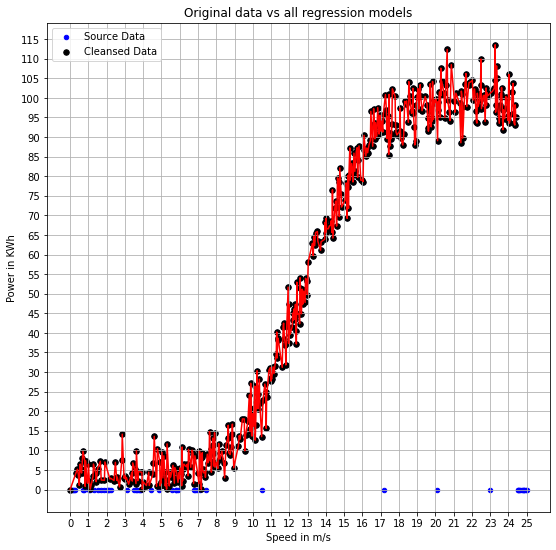

In [3]:
# Plot the data
plt.figure(figsize = (9, 9))                                    # Set the plot size
plt.plot(cleansed_df["speed"], cleansed_df["power"], color = "r")   # Plot the speed and power on a graph, with red lines between the points
plt.scatter(x = source_df["speed"], y = source_df["power"], s = 20, color = "b", label = "Source Data") # Plot the speed and power on a graph, as black points
plt.scatter(x = cleansed_df["speed"], y = cleansed_df["power"], s = 30, color = "k", label = "Cleansed Data") # Plot the speed and power on a graph, as black points
plt.xticks(np.arange(0, round(cleansed_df["speed"].max(), 0) + 2, step = 1)) # Force all the xticks to be visible
plt.yticks(np.arange(0, round(cleansed_df["power"].max(), 0) + 4, step = 5)) # Force all the xticks to be visible
plt.grid(which = "major", axis = "x")                           # Show the minor grid lines on the x axis
plt.grid(which = "major", axis = "y")                           # Show the minor grid lines on the y axis
plt.ylabel("Power in KWh")                                      # Label the y axis
plt.xlabel("Speed in m/s")                                      # Label the x axis
plt.legend(loc = "best")                                        # Put the legend in the best place
plt.title("Original data vs all regression models")             # Title of the graph
plt.show()                                                      # Show the graph

### Splitting data

In [4]:
# Splitting data into training and testing arrays
sp_ar, po_ar = cleansed_df["speed"].values, cleansed_df["power"].values # Split the data into separate speed and power arrays

sp_train_ar, sp_test_ar, po_train_ar, po_test_ar = train_test_split(sp_ar, po_ar, test_size = 0.25, random_state = 0)   # Split the arrays into traing (75%) and training (25%) arrays, using random state value 64676

print("Training set: %d rows\nTest set: %d rows" %(sp_train_ar.size, sp_test_ar.size))  # Print the size of the training and testing arrays

Training set: 339 rows
Test set: 113 rows


## Linear Regression

### What is linear regression?


### How does it work?


### Code actions

In [5]:
lin_model = LinearRegression(fit_intercept=False).fit(sp_train_ar.reshape(-1,1), po_train_ar)   # Create the linear regression model, using the speed and power trainign arrays.
                                                                                                # Note that the intercept is set to 0, as there should not be negative power.
predictions_lin = lin_model.predict(sp_test_ar.reshape(-1,1))   # Use the model to predict the power values using the speed test array 

filename_lin ="Models/lin_reg.pkl"                              # State the file save location
joblib.dump(lin_model, filename_lin)                            # Save the model as lin_reg in the model folder

mse_lin = mean_squared_error(po_test_ar, predictions_lin)       # Determine the mean squared error of the linear regression model
print("mse_lin:", mse_lin)

rmse_lin = np.sqrt(mse_lin)                                     # Determine the root mean squared error of the linear regression model
print("rmse_lin:", rmse_lin)

r2_lin = r2_score(po_test_ar, predictions_lin)                  # Determine the square of the correlation of the linear regression model
print("R2_lin:", r2_lin)

mse_lin: 241.40831804070257
rmse_lin: 15.537320169215237
R2_lin: 0.8476406987704058


## Decision Tree Regressor

In [6]:
DTR_model = DecisionTreeRegressor().fit(sp_train_ar.reshape(-1,1), po_train_ar) # Create the decision tree model, using the speed and power training arrays

predictions_DTR = DTR_model.predict(sp_test_ar.reshape(-1,1))   # Use the model to predict the power values using the speed test array

filename_DTR ="Models/DTR.pkl"                                  # State the file save location
joblib.dump(DTR_model, filename_DTR)                            # Save the model as DTR in the model folder

mse_DTR = mean_squared_error(po_test_ar, predictions_DTR)       # Determine the mean squared error of the decision tree regression model
print("mse_DTR:", mse_DTR)                                      

rmse_DTR = np.sqrt(mse_DTR)                                     # Determine the root mean squared error of the decision tree regression model
print("rmse_DTR:", rmse_DTR)

r2_DTR = r2_score(po_test_ar, predictions_DTR)                  # Determine the square of the correclation of the decision tree regression model
print("R2_lin:", r2_DTR)

mse_DTR: 28.32833074336284
rmse_DTR: 5.322436541976131
R2_lin: 0.982121226343444


## Random Forest

In [7]:
RFR_model = RandomForestRegressor().fit(sp_train_ar.reshape(-1,1), po_train_ar) # Create the random forest model, using the speed and power training arrays

predictions_RFR = RFR_model.predict(sp_test_ar.reshape(-1,1))   # Use the model to predict the power values using the speed test array 

filename_RFR ="Models/RFR.pkl"                                  # State the file save location
joblib.dump(RFR_model, filename_RFR)                            # Save the model as RFR in the model folder

mse_RFR = mean_squared_error(po_test_ar, predictions_RFR)       # Determine the mean squared error of the random forest regression model
print("mse_RFR:", mse_RFR)

rmse_RFR = np.sqrt(mse_RFR)                                     # Determine the root mean squared error of the random forest regression model
print("rmse_RFR:", rmse_RFR)

r2_RFR = r2_score(po_test_ar, predictions_RFR)                  # Determine the square of the correlation of the random forset regression model
print("R2_lin:", r2_RFR)

mse_RFR: 21.71898781592122
rmse_RFR: 4.660363485386223
R2_lin: 0.9862925609444414


## Sigmoid Regression

In [8]:
def sigmoid(x, L ,x0, k, b):                                    # Function to define the sigmoid
    y = L / (1 + np.exp(-k*(x-x0)))+b                           # Sigmoid formula
    return (y)                                                  # Return the coefficients for the sigmoid curve

p0 = [max(po_train_ar), np.median(sp_train_ar), 1, min(po_train_ar)]    # Initial guess to start the sigmoid coefficients

popt, pcov = curve_fit(sigmoid, sp_train_ar, po_train_ar, p0, method='dogbox')  # Find the optimized values for the parameters (popt) and covariance of popt

predict_sig = sigmoid(sp_test_ar, *popt)                        # USe the sigmoid optimised values to predict the power values using the speed test array

# Mean squared error
mse_SIG = mean_squared_error(predict_sig, po_test_ar)           # Use sklearn's mean_squared_error to determine the mean squared error of the sigmoid model
print("mse_SIG:", mse_SIG)

# Root mean squared error
rmse_SIG = np.sqrt(mse_SIG)                                     # Determine the root mean squared error of the sigmoid model
print("RMSE_SIG:", rmse_SIG)

# r squared calculations
r_matrix = np.corrcoef(po_test_ar, predict_sig)                 # Create a matric of the correlation coefficients of the predicted and actual power values using the power test array
r = r_matrix[0,1]                                               # Choose the values at [0,1] from the matrix to determine the correlation coefficient       
r2_SIG = r**2                                                   # Get r squared by squaring r
print("R2_SIG", r2_SIG)

# Save arrays for later use 
np.savetxt("Models/popt.csv", popt, delimiter = ",")            # Export the popt values for later reuse

mse_SIG: 16.912260029973346
RMSE_SIG: 4.112451827070239
R2_SIG 0.9901655840397021


## Predictions

In [9]:
# Import the models that are needed to predict the outputs
lin_model_load = joblib.load(filename_lin)                      # Reimport the linear regression model
DTR_model_load = joblib.load(filename_DTR)                      # Reimport the decision tree regression model
RFR_model_load = joblib.load(filename_RFR)                      # Reimport the random forest regression model

Analysis_df = pd.DataFrame(columns = ["speed", "power", "Lin P", "RFR P", "DTR P", "Sig P", "AMEL", "AMER", "AMED", "AMES"])    # Create a new dataframe for the further analysis

j = 0                                                           # Used to iterate through the rows of the cleansed and analysis dataframes

while j < len(cleansed_df.index):                               # Iterate through the cleansed_df 
    
    i = cleansed_df.iloc[j]["speed"]                            # Let i equal the speed value from the cleansed_df
    speed = np.full(shape=1, fill_value=i, dtype="float64").reshape(-1, 1)  # Create a 1d array with the speed value
    Analysis_df.loc[j, "speed"] = i                             # Introduce the speed value to the correct location in the analysis_df
    Analysis_df.loc[j, "power"] = cleansed_df.iloc[j]["power"]  # Introduce the power value to the correct location in the analysis_df
    Analysis_df.loc[j, "Lin P"] = np.round(lin_model_load.predict(speed)[0], 3)    # Load the speed value into the linear regression model, and enter the result into the analysis_df
    Analysis_df.loc[j, "RFR P"] = np.round(RFR_model_load.predict(speed)[0], 3)    # Load the speed value into the random forest regression model, and enter the result into the analysis_df
    Analysis_df.loc[j, "DTR P"] = np.round(DTR_model_load.predict(speed)[0], 3)    # Load the speed value into the decision tree regression model, and enter the result into the analysis_df
    Analysis_df.loc[j, "Sig P"] = np.round(sigmoid(i, *popt), 3)   # Load the speed value intot the sigmoid model, and enter the result into the analysis_df
    Analysis_df.loc[j, "AMEL"] = abs(Analysis_df.loc[j, "power"] - Analysis_df.loc[j, "Lin P"]) # Determine the absolute difference between the linear regression estimate, and the actual recorded values for the power
    Analysis_df.loc[j, "AMER"] = abs(Analysis_df.loc[j, "power"] - Analysis_df.loc[j, "RFR P"]) # Determine the absolute difference between the random forest regression estimate, and the actual recorded values for the power
    Analysis_df.loc[j, "AMED"] = abs(Analysis_df.loc[j, "power"] - Analysis_df.loc[j, "DTR P"]) # Determine the absolute difference between the decision tree regression estimate, and the actual recorded values for the power
    Analysis_df.loc[j, "AMES"] = abs(Analysis_df.loc[j, "power"] - Analysis_df.loc[j, "Sig P"]) # Determine the absolute difference between the sigmoid model estimate, and the actual recorded values for the power
    j += 1                                                      # Increment the row by one
    
Analysis_df = Analysis_df.apply(pd.to_numeric, errors="coerce") # Force all the dtypes to be floats

# Determine the absolute mean error
AMEL = Analysis_df["AMEL"].sum() / j                            # Sum the analysis_df values of the absolute differences for the linear regression and divide by the number of rows
AMER = Analysis_df["AMER"].sum() / j                            # Sum the analysis_df values of the absolute differences for the random forest regression and divide by the number of rows
AMED = Analysis_df["AMED"].sum() / j                            # Sum the analysis_df values of the absolute differences for the decision tree regression and divide by the number of rows
AMES = Analysis_df["AMES"].sum() / j                            # Sum the analysis_df values of the absolute differences for the sigmoid and divide by the number of rows

table = PrettyTable(["Model", "Mean Squared Error", "Root Mean Squared Error", "R square %", "Absolute Mean Error"])    
table.add_row(["Linear Regression", np.round(mse_lin, 3), np.round(rmse_lin, 3), np.round(r2_lin * 100, 3), np.round(AMEL, 3)])
table.add_row(["Decision Tree Regression", np.round(mse_DTR, 3), np.round(rmse_DTR, 3), np.round(r2_DTR * 100, 3), np.round(AMED, 3)])
table.add_row(["Random Tree Regression", np.round(mse_RFR, 3), np.round(rmse_RFR, 3), np.round(r2_RFR * 100, 3), np.round(AMER, 3)])
table.add_row(["Sigmoid Model", np.round(mse_SIG, 3), np.round(rmse_SIG, 3), np.round(r2_SIG * 100, 3), np.round(AMES, 3)])

print(table)

+--------------------------+--------------------+-------------------------+------------+---------------------+
|          Model           | Mean Squared Error | Root Mean Squared Error | R square % | Absolute Mean Error |
+--------------------------+--------------------+-------------------------+------------+---------------------+
|    Linear Regression     |      241.408       |          15.537         |   84.764   |        13.318       |
| Decision Tree Regression |       28.328       |          5.322          |   98.212   |        1.057        |
|  Random Tree Regression  |       21.719       |           4.66          |   98.629   |        1.967        |
|      Sigmoid Model       |       16.912       |          4.112          |   99.017   |        3.222        |
+--------------------------+--------------------+-------------------------+------------+---------------------+


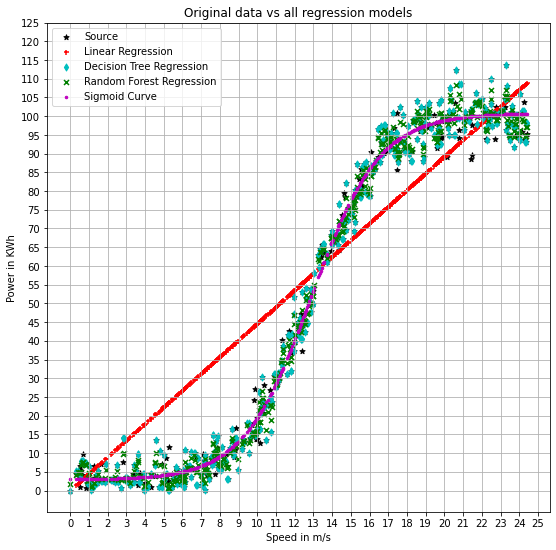

In [10]:
plt.figure(figsize = (9,9))                                     # Set the size of the plot area
plt.scatter(cleansed_df["speed"], cleansed_df["power"], s = 30, color = "k", marker = "*", label = "Source")    # Create a scatter graph using the cleansed data
plt.scatter(Analysis_df["speed"], Analysis_df["Lin P"], s = 25, color = "r", marker = "+", label = "Linear Regression") # Create a scatter graph using the linear regression estimates from the analysed data
plt.scatter(Analysis_df["speed"], Analysis_df["DTR P"], s = 25, color = "c", marker = "d", label = "Decision Tree Regression")  # Create a scatter graph using the decision tree regression estimates from the analysed data
plt.scatter(Analysis_df["speed"], Analysis_df["RFR P"], s = 25, color = "g", marker = "x", label = "Random Forest Regression")  # Create a scatter graph using the random forest regression estimates from the analysed data
plt.scatter(Analysis_df["speed"], Analysis_df["Sig P"], s = 25, color = "m", marker = ".", label = "Sigmoid Curve") # Create a scatter graph using the sigmoid model estimated from the analysed data
plt.xticks(np.arange(0, round(cleansed_df["speed"].max(), 0) + 2, step = 1))    # Force all the xticks to be visible
plt.yticks(np.arange(0, round(Analysis_df[["power", "Lin P", "DTR P", "RFR P", "Sig P"]].max(axis=1)[j-1] + 18), step = 5)) # Force all the xticks to be visible
plt.grid(which = "major", axis = "x")                           # Show the minor grid lines on the x axis
plt.grid(which = "major", axis = "y")                           # Show the minor grid lines on the y axis
plt.ylabel("Power in KWh")                                      # Label for the y axis
plt.xlabel("Speed in m/s")                                      # Label for the x axis
plt.legend(loc = "best")                                        # Determine the best location for the legend to be places
plt.title("Original data vs all regression models")             # Title for the chart
plt.show()                                                      # Plot the graphs

In [11]:
while True:
    try:
        value = float(input("Input a positive value for the wind speed in m/s:"))   # Request input value from user, and converts from string to float

    except ValueError:                                          # Error/exception handling
        print("Sorry, I did not understand that entry")                 
        continue

    if value < 0:                                               # Check if number positive, as wind speed cannot be negative
        print("Sorry, you can't have negative wind speed")      # Continue with the loop
        continue

    else:
        break                                                   # Break out of the loop

speed_new = np.full(shape=1, fill_value=value, dtype="float64").reshape(-1, 1)  # Input the user provided speed value into a 1d array

print()
print("Choose the which model you would like to try:")
print("1: Linear regression.")
print("2: Random Forest.")
print("3: Decision Tree.")
print("4: Sigmoid Analysis")
print()

while True:
    try:
        model = int(input("Choose the regression model to estimate the power to be generated:"))    # Choose one to the regression models to use

    except ValueError:                                          # Error/exception handling
        print("Sorry, I did not understand that entry")                 
        continue

    if model <= 0 or model > 4:                                 # Check if the number is within the bounds 1 - 4
        print("Sorry, that number is not within the bounds allowed")    # Continue with the loop
        continue

    else:
        break                                                   # Break out of the loop

if model == 1:                                                  # Linear regression model
        result = lin_model_load.predict(speed_new)              # Input the user provided speed into the linear regression model
    
elif model == 2:                                                # Random forest regression model
    result = RFR_model_load.predict(speed_new)                  # Input the user provided speed into the random forest regression model

elif model == 3:                                                # Decision tree regression model
    result = DTR_model_load.predict(speed_new)                  # Input the user provided speed into the decision tree regression model

elif model == 4:                                                # Sigmoid model
    result = sigmoid(speed_new, *popt)                          # Input the user provided speed into the sigmoid model

kmh = speed_new * 3.6                                           # Convert the user provided speed into kilometers per hour
MPH = speed_new * 2.23694                                       # Convert the user provided speed into miles per hour

print()
if speed_new > 70:                                              # If the user provided speed equates to more than 70 m/s (huricane category 5)
    print("Warning:\nThis wind speed indicates that there is a category 5 hurricane blowing.\nThis faster than the highest recorded wind speed in Ireland.\n\n")

elif speed_new > 58.05556:                                      # If the user provided speed equates to more than 58.055 m/s (huricane category 4)
    print("Warning:\nThis wind speed indicates that there is a category 4 hurricane blowing.\nThis faster than the highest recorded wind speed in Ireland.\n\n")

elif speed_new > 50.55556:                                      # If the user provided speed equates to more than 50.555 m/s (the highest wind speed ever recorded in Ireland)
    print("Warning:\nThis wind speed indicates that there is a category 3 hurricane blowing.\nThis faster than the highest recorded wind speed in Ireland.\n\n")

elif speed_new > 49.44444:                                      # If the user provided speed equates to more than 49.444 m/s (huricane category 3)
    print("Warning:\nThis wind speed indicates that there is a category 3 hurricane blowing.\n\n")

elif speed_new > 42.77778:                                      # If the user provided speed equates to more than 42.777 m/s (huricane category 2)
    print("Warning:\nThis wind speed indicates that there is a category 2 hurricane blowing.\n\n")

elif speed_new > 33.05556:                                      # If the user provided speed equates to more than 33.055 m/s (huricane category 1)
    print("Warning:\nThis wind speed indicates that there is a category 1 hurricane blowing.\n\n")

elif speed_new > 28.61111:                                      # If the user provided speed equate to more than 28.611 m/s (storm force winds)
    print("Warning:\nThis wind speed indicates that there is a storm blowing.\n\n")

print("Estimated power produced at wind speed of %.3f m/s (%.2f km/h, %.2f MPH) is %.3f kW/h." % (speed_new, kmh, MPH, result[0]))  # Print the estimated power generated by the user inputted wind speed

Input a positive value for the wind speed in m/s:89

Choose the which model you would like to try:
1: Linear regression.
2: Random Forest.
3: Decision Tree.
4: Sigmoid Analysis

Choose the regression model to estimate the power to be generated:4

This wind speed indicates that there is a category 5 hurricane blowing.
This faster than the highest recorded wind speed in Ireland.


Estimated power produced at wind speed of 89.000 m/s (320.40 km/h, 199.09 MPH) is 100.780 kW/h.
